In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from feedback_model import FeedbackModel
import utils

In [2]:
WINDOW_SIZE = 24
FORECAST_PERIOD = 24
BATCH_SIZE = 32
LABEL_NAME = 'T (degC)'

In [3]:
df_train, df_val, df_test = utils.load_data()
print(f"df_train.shape = {df_train.shape}, df_val.shape = {df_val.shape}, df_test.shape = {df_test.shape}")

df_train.shape = (49063, 19), df_val.shape = (14018, 19), df_test.shape = (7010, 19)


In [4]:
num_features = len(df_train.columns)
num_features

19

In [5]:
def build_dataset(df_data, window_size, forecast_period, batch_size, shuffle=True):
    data = np.array(df_data, dtype=np.float32)
    ds = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size + forecast_period,
        sequence_stride=window_size,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    # Note: Use batched_window[:, 1: ...
    ds = ds.map(lambda batched_window: (batched_window[:, :window_size, :], batched_window[:, window_size:, :]))
    return ds

In [6]:
train_ds = build_dataset(df_train, WINDOW_SIZE, FORECAST_PERIOD, BATCH_SIZE, shuffle=False)

for x_batch, y_batch in train_ds.take(1):
    print(f"x_batch.shape = {x_batch.shape}")
    print(f"y_batch.shape = {y_batch.shape}")

x_batch.shape = (32, 24, 19)
y_batch.shape = (32, 24, 19)


In [7]:
train_ds = build_dataset(df_train, WINDOW_SIZE, FORECAST_PERIOD, BATCH_SIZE)
val_ds = build_dataset(df_val, WINDOW_SIZE, FORECAST_PERIOD, BATCH_SIZE)

In [8]:
model = FeedbackModel(units=32, forecast_period=FORECAST_PERIOD, num_features=num_features)

In [9]:
prediction, state = model.warmup(x_batch)
prediction.shape

TensorShape([32, 19])

In [10]:
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

history = model.fit(
    train_ds, 
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
64/64 [==============================] - 5s 74ms/step - loss: 0.7611 - mean_absolute_error: 0.6783 - val_loss: 0.6081 - val_mean_absolute_error: 0.5938
Epoch 2/20
64/64 [==============================] - 4s 59ms/step - loss: 0.5571 - mean_absolute_error: 0.5624 - val_loss: 0.5453 - val_mean_absolute_error: 0.5545
Epoch 3/20
64/64 [==============================] - 4s 58ms/step - loss: 0.4984 - mean_absolute_error: 0.5270 - val_loss: 0.4964 - val_mean_absolute_error: 0.5275
Epoch 4/20
64/64 [==============================] - 4s 59ms/step - loss: 0.4220 - mean_absolute_error: 0.4792 - val_loss: 0.4173 - val_mean_absolute_error: 0.4763
Epoch 5/20
64/64 [==============================] - 4s 59ms/step - loss: 0.3570 - mean_absolute_error: 0.4303 - val_loss: 0.3651 - val_mean_absolute_error: 0.4374
Epoch 6/20
64/64 [==============================] - 4s 59ms/step - loss: 0.3251 - mean_absolute_error: 0.4034 - val_loss: 0.3334 - val_mean_absolute_error: 0.4115
Epoch 7/20
64/64 [====

In [11]:
new_data = df_val.iloc[:WINDOW_SIZE].to_numpy()
new_data = np.expand_dims(new_data, 0)
forecast = model.predict(new_data)
forecast = tf.squeeze(forecast).numpy()
actual = df_val.iloc[WINDOW_SIZE:WINDOW_SIZE + FORECAST_PERIOD].to_numpy()
print(f"forecast.shape = {forecast.shape}, actual.shape = {actual.shape}")

forecast.shape = (24, 19), actual.shape = (24, 19)


In [14]:
ae = np.abs(forecast - actual)
mae = np.mean(ae, axis=0)
mae

array([0.51693027, 0.20278785, 0.18992642, 0.1207515 , 0.47058422,
       0.24625329, 0.28646907, 0.45006596, 0.3167378 , 0.30177713,
       0.34795291, 0.4279267 , 0.54336602, 0.44320858, 0.5544356 ,
       0.21853566, 0.19551009, 0.06937422, 0.16002025])

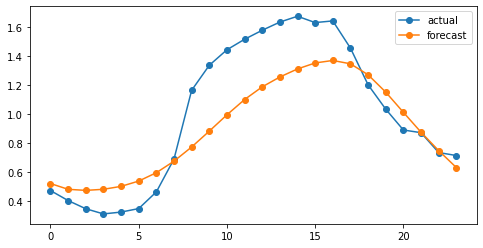

mse = 0.0632, mae = 0.2028


In [15]:
LABEL_NAME = 'T (degC)'
label_idx = list(df_train.columns).index(LABEL_NAME)
utils.plot_result(actual[:, label_idx], forecast[:, label_idx])
utils.evaluate(actual[:, label_idx], forecast[:, label_idx])